In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.animation as animation
import csv
import os
import time

np.random.seed(1234)

In [3]:
# CUDA support
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA")
else:
    device = torch.device("cpu")
    print("CPU")

CUDA


In [4]:
class DNN(nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
        self.activation = nn.Tanh()

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        return self.layers[-1](x)

In [76]:
lbfgs_lr = 0.1
adam_lr = 0.01

w_pde = 1.0
w_bc = 1.0
w_ic = 1.0

In [100]:
class PINN():
    def __init__(self, X, layers, lb, rb, f, ic1, ic2):
        
        self.x_all = X["all"][0]
        self.t_all = X["all"][1]

        self.x_bc_lb = X["bc_lb"][0]
        self.t_bc_lb = X["bc_lb"][1]
        self.x_bc_rb = X["bc_rb"][0]
        self.t_bc_rb = X["bc_rb"][1]

        self.x_ic = X["ic"][0]
        self.t_ic = X["ic"][0]

        self.f = f
        self.ic1 = ic1
        self.ic2 = ic2

        self.lb = lb
        self.rb = rb

        # DNN
        self.dnn = DNN(layers).to(device)

        # Optimizer
        self.optimizer_lbfgs = torch.optim.LBFGS(
            self.dnn.parameters(),
            lr=lbfgs_lr,
            max_iter=50000,
            max_eval=50000,
            history_size=50,
            tolerance_grad=1e-5,
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"
        )

        self.optimizer_adam = torch.optim.Adam(self.dnn.parameters(), lr=adam_lr)
        self.iter = 0

    def model_value(self, x, t):
        u = self.dnn(torch.stack([x, t], dim=1))
        return u
    
    def space_derivative(self, u, x):
        u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
        u_2x = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]
        u_3x = torch.autograd.grad(u_2x, x, torch.ones_like(u_2x), create_graph=True)[0]
        u_4x = torch.autograd.grad(u_3x, x, torch.ones_like(u_3x), create_graph=True)[0]      

        return u_x, u_2x, u_3x, u_4x
    
    def time_derivative(self, u , t):
        u_t = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]
        u_2t = torch.autograd.grad(u_t, t, torch.ones_like(u_t), create_graph=True)[0]

        return u_t, u_2t

    def boundary_condition(self, cond, x, t):
        u = self.model_value(x, t)
        bc_loss = 0
        u_x, u_2x, u_3x, _ = self.space_derivative(u, x)

        match cond:
            case 'pinned':
                bc_loss += torch.mean(u**2) + torch.mean(u_2x**2)
            case 'fixed':
                bc_loss += torch.mean(u**2) + torch.mean(u_x**2)
            case 'free':
                bc_loss += torch.mean(u_2x**2) + torch.mean(u_3x**2)
            case 'roller':
                bc_loss += torch.mean(u_x**2) + torch.mean(u_3x**2)

        return bc_loss
    
    def initial_condition(self, x, t):
        u = self.model_value(x, t)
        u_t, _ = self.time_derivative(u, t)

        ic_loss = torch.mean((u - self.ic1)**2)
        ic_loss += torch.mean((u_t - self.ic2)**2)

        return ic_loss

    def pde(self, x, t):
        u = self.model_value(x, t)
        _, _, _, u_4x = self.space_derivative(u, x)
        _, u_2t = self.time_derivative(u, t)
        
        pde_loss = torch.mean((u_2t + u_4x - self.f)**2)

        return pde_loss

    def loss_func(self):
        pde_loss = self.pde(self.x_all, self.t_all)
        bc_loss = self.boundary_condition(self.lb, self.x_bc_lb, self.t_bc_lb)
        bc_loss += self.boundary_condition(self.rb, self.x_bc_rb, self.t_bc_rb)
        ic_loss = self.initial_condition(self.x_ic, self.t_ic)

        total_loss = w_pde*pde_loss + w_bc*bc_loss + w_ic*ic_loss
        return total_loss


    def lbfgs_func(self):
        loss = self.loss_func()

        self.optimizer_lbfgs.zero_grad()
        loss.backward(retain_graph=True)

        self.iter += 1
        if self.iter % 100 == 0:
            print(f"Iter: {self.iter}, Loss: {'{:e}'.format(loss.item())}")
        return loss
    
    def train(self, epochs=1000):
        self.dnn.train()
        for epoch in range(epochs):
            loss = self.loss_func()

            self.optimizer_adam.zero_grad()
            loss.backward(retain_graph=True)
            self.optimizer_adam.step()

            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Loss: {'{:e}'.format(loss.item())}")

        self.optimizer_lbfgs.step(self.lbfgs_func)

    def predict(self, x, t):
        self.dnn.eval()
        u = self.model_value(x, t)
        u = u.detach().cpu().numpy()

        final_loss = self.loss_func()
        final_loss = final_loss.detach().cpu().numpy()
        return u, final_loss[0]

In [101]:
def func(x, t):
    return (1-16*np.pi**2) * np.sin(x) * np.cos(4*np.pi*t)

In [102]:
def ic_points(n_points):
    x = torch.rand(n_points, device=device)
    t = torch.zeros(n_points, device=device)
    return torch.stack([x, t], dim=1)

def bc_points(n_points, x_bc):
    x = torch.ones(n_points, device=device) * x_bc
    t = torch.rand(n_points, device=device)
    return torch.stack([x, t], dim=1)

def domain_points(n_points):
    x = torch.rand(n_points, device=device)
    t = torch.rand(n_points, device=device)
    return torch.stack([x, t], dim=1)

In [103]:
def generate_points(points):
    def ic_points(n_points):
        x = torch.rand(n_points, device=device).requires_grad_()
        t = torch.zeros(n_points, device=device).requires_grad_()
        return x, t

    def bc_points(n_points, x_bc):
        x = torch.ones(n_points, device=device).requires_grad_() * x_bc
        t = torch.rand(n_points, device=device).requires_grad_()
        return x, t

    def domain_points(n_points):
        x = torch.rand(n_points, device=device).requires_grad_()
        t = torch.rand(n_points, device=device).requires_grad_()
        return x, t

    x_d, t_d = domain_points(points[0])
    x_bc_lb, t_bc_lb = bc_points(points[1], 0)
    x_bc_rb, t_bc_rb = bc_points(points[1], torch.pi)
    x_ic, t_ic = ic_points(points[2])

    x_all = torch.cat([x_d, x_bc_lb, x_bc_rb, x_ic], dim=0)
    t_all = torch.cat([t_d, t_bc_lb, t_bc_rb, t_ic], dim=0)


    generated_points = {"all": [x_all, t_all], "bc_lb": [x_bc_lb, t_bc_lb], "bc_rb": [x_bc_rb, t_bc_rb], "ic": [x_ic, t_ic]}
    return generated_points


In [104]:
points = [100, 10, 20]
collocation = generate_points(points)


all_x = collocation["all"][0]
all_t = collocation["all"][1]

ic_x = collocation["ic"][0]

f = lambda x, t: (1 - 16*torch.pi**2)*torch.sin(x)*torch.cos(4*torch.pi*t)
ic1 = lambda x: torch.sin(x)
ic2 = lambda x: torch.full_like(x, 0)

vec1 = ic1(ic_x)
vec2 = ic2(ic_x)
fun = f(all_x, all_t)

In [105]:
nodes = 20
layers = [2, nodes, nodes, nodes, nodes, nodes, 1]
lb = 'pinned'
rb = 'pinned'

model = PINN(collocation, layers, lb, rb, fun, vec1, vec2)

In [106]:
model.train(1000)

Epoch 0, Loss: 3.473354e+03
Epoch 100, Loss: 2.067152e+03
Epoch 200, Loss: 2.002648e+02
Epoch 300, Loss: 2.291714e+01
Epoch 400, Loss: 1.151099e+01
Epoch 500, Loss: 1.019664e+01
Epoch 600, Loss: 6.780859e+00
Epoch 700, Loss: 5.747328e+00
Epoch 800, Loss: 6.184627e+00
Epoch 900, Loss: 4.829250e+00
Iter: 100, Loss: 1.711190e+00
Iter: 200, Loss: 1.234754e+00
Iter: 300, Loss: 9.808630e-01
Iter: 400, Loss: 8.202672e-01
Iter: 500, Loss: 6.786704e-01
Iter: 600, Loss: 5.527055e-01
Iter: 700, Loss: 4.239085e-01
Iter: 800, Loss: 3.208866e-01
Iter: 900, Loss: 2.736241e-01
Iter: 1000, Loss: 2.363054e-01
Iter: 1100, Loss: 2.070344e-01
Iter: 1200, Loss: 1.715436e-01
Iter: 1300, Loss: 1.545307e-01
Iter: 1400, Loss: 1.413466e-01
Iter: 1500, Loss: 1.251030e-01
Iter: 1600, Loss: 1.144296e-01
Iter: 1700, Loss: 1.064127e-01
Iter: 1800, Loss: 9.890639e-02
Iter: 1900, Loss: 9.151384e-02
Iter: 2000, Loss: 8.791962e-02
Iter: 2100, Loss: 8.300500e-02
Iter: 2200, Loss: 7.944685e-02
Iter: 2300, Loss: 7.747732e-0

KeyboardInterrupt: 

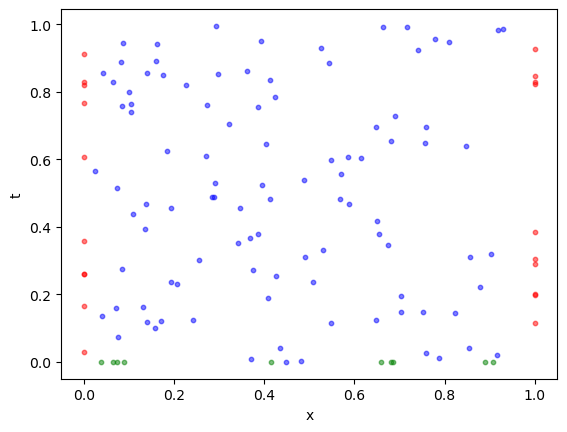

In [ ]:

d = domain_points(100)
bc_lb = bc_points(10, 0)
bc_rb = bc_points(10, 1)
ic = ic_points(10)

x1 = d[:, 0].cpu().numpy()
t1 = d[:, 1].cpu().numpy()

x2 = bc_lb[:, 0].cpu().numpy()
t2 = bc_lb[:, 1].cpu().numpy()

x3 = bc_rb[:, 0].cpu().numpy()
t3 = bc_rb[:, 1].cpu().numpy()

x4 = ic[:, 0].cpu().numpy()
t4 = ic[:, 1].cpu().numpy()

plt.scatter(x1, t1, s=10, color="blue", alpha=0.5)
plt.scatter(x2, t2, s=10, color="red", alpha=0.5)
plt.scatter(x3, t3, s=10, color="red", alpha=0.5)
plt.scatter(x4, t4, s=10, color="green", alpha=0.5)
plt.xlabel("x")
plt.ylabel("t")
plt.show()


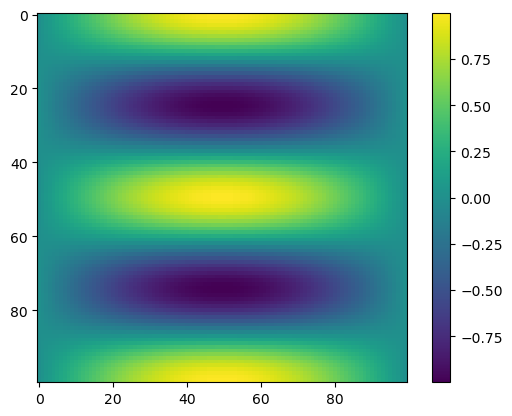

In [11]:

# Exact solution

def exact_solution(x, t):
    return np.sin(x)*np.cos(4*np.pi*t)


x = np.linspace(0, np.pi, 100)
t = np.linspace(0, 1, 100)

X, T = np.meshgrid(x, t)
U = np.sin(X) * np.cos(4 * np.pi * T) 

plt.imshow(U)
plt.colorbar()
plt.show()

# # Set up the figure and axis
# fig, ax = plt.subplots()
# ax.set_xlim(0, np.pi)
# ax.set_ylim(-1, 1)
# ax.set_xlabel("x")
# ax.set_ylabel("u(x, t)")
# ax.set_title("Animation of Exact Solution")


# # Initialize the line object
# line, = ax.plot([], [], lw=2)

# # Initialization function: Clears the line data
# def init():
#     line.set_data([], [])
#     return line,

# # Update function for each frame
# def update(frame):
#     y = exact_solution(x, t[frame])  # Compute solution at current time step
#     line.set_data(x, y)
#     return line,

# # Create the animation
# ani = animation.FuncAnimation(fig, update, frames=len(t), init_func=init, blit=True, interval=50)

# ani.save("wave_animation.gif", writer="pillow", fps=30)

In [13]:


X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
           

# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0) 

print(X_star)
print(lb)
print(ub)

[[0.         0.        ]
 [0.03173326 0.        ]
 [0.06346652 0.        ]
 ...
 [3.07812614 1.        ]
 [3.10985939 1.        ]
 [3.14159265 1.        ]]
[0. 0.]
[3.14159265 1.        ]


In [109]:
# Define the resolution of the grid
x_min, x_max = 0, np.pi  # X range
t_min, t_max = 0, 1  # Time range
grid_size = 10  # Number of points in each dimension

# Create a meshgrid
x_vals = np.linspace(x_min, x_max, grid_size)
t_vals = np.linspace(t_min, t_max, grid_size)
X, T = np.meshgrid(x_vals, t_vals)  # Create a 2D meshgrid

# Flatten the meshgrid and convert to PyTorch tensor
X_flat = torch.tensor(X.flatten(), dtype=torch.float32, device=device)
T_flat = torch.tensor(T.flatten(), dtype=torch.float32, device=device)


u_pred, loss = model.predict(X_flat, T_flat)

# Reshape predictions back into a 2D grid
U_pred_reshaped = u_pred.reshape(grid_size, grid_size)

# Plot the result
plt.figure(figsize=(8, 6))
plt.contourf(X, T, U_pred_reshaped, cmap="jet")
plt.colorbar(label="Predicted Output (U)")
plt.xlabel("x-coordinate")
plt.ylabel("Time (t)")
plt.title("PINN Predicted Solution")
plt.show()

IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed